---
title: "✅ Week 10 - Student Solutions"
subtitle: Introduction to Natural Language Processing in Python
author: "MY NAME (MY CANDIDATE NUMBER)"
date: 24 March 2025
---

Let's begin by loading the relevant packages.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import gensim
import shap
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from lets_plot import *
LetsPlot.setup_html()

# Load spaCy stopwords
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

# Introducing a new data set (10 minutes)

We'll begin by loading data on 2,563 statements on economic matters by the European Central Bank (ECB), available [here](https://github.com/Moritz-Pfeifer/CentralBankRoBERTa/blob/main/Data/Labelled_data/Sentiment/ECB_prelabelled_sent.csv).  Statements by the ECB offer valuable insights into the economic policies and decisions that shape the financial landscape of the European Union. The ECB plays a critical role in regulating monetary policy, controlling inflation, managing interest rates, and ensuring economic stability across member states. Understanding how the ECB communicates its strategies and decisions helps students grasp broader economic concepts like central banking, economic growth, and market reactions. Additionally, ECB statements can reveal the political dynamics at play within the European Union, highlighting how economic policies influence social issues such as unemployment, inequality, and public welfare.

There are two variables:

-   `text`: Economic statements.
-   `sentiment`: Whether the statement is positive (1) or negative (0).

In [2]:
# Load data
statements = pd.read_csv("../data/ECB_prelabelled_sent.txt")

# Print the data frame
print(statements)

                                                   text  sentiment
0     target2 is seen as a tool to promote the furth...          1
1     the slovak republic for example is now home to...          1
2     the earlier this happens the earlier economic ...          1
3     the bank has made essential contributions in k...          1
4     moreover the economic size and welldeveloped f...          1
...                                                 ...        ...
2558  several are facing an unavoidable period of do...          0
2559  in fact at present the situation of subdued ec...          0
2560  for instance recent research based on european...          0
2561  incidentally the identification of the disturb...          0
2562  however being more visible in the single curre...          0

[2563 rows x 2 columns]


👉 **NOTE:** As you can see, we have a series of statements that convey information about a specific economic topic and an attached sentiment.  However, the text data, as it stands, is not very useful but, with a few Python commands can be transformed into useful features.

# Creating our first document feature matrix (20 minutes)

A document feature matrix (DFM) has an identical number of rows to the text column used to create it, and a given number of features, consisting of n-grams (n words seperated by white space) specified by the user.  The below code turns the text column into a document feature matrix.

**🎯 Action Point:** Try your best to understand the code - don't worry if you don't, we will go over the code together.

In [3]:
# Preprocess function: tokenize, remove punctuation, numbers, and stopwords
def preprocess_text(text):
    doc = nlp(text.lower())  # Lowercase text
    tokens = [
        token.lemma_ for token in doc 
        if not token.is_punct and not token.is_digit and not token.is_space 
        and token.text.lower() not in stopwords
    ]
    return " ".join(tokens)  # Return cleaned text as a string

# Apply preprocessing to each review
statements["text_cleaned"] = statements["text"].apply(preprocess_text)

# Create document-feature matrix (DFM) using CountVectorizer
vectorizer = CountVectorizer(min_df=10)
dfm = vectorizer.fit_transform(statements["text_cleaned"])

# Convert to a DataFrame for inspection
dfm = pd.DataFrame(dfm.toarray(), columns=vectorizer.get_feature_names_out())

👉 **NOTE:** 
-   We create a count of each token in a given document, specifying that terms should occur in at least 10 documents in order to be included in the final DFM.
-   We have used a pre-selected list of stopwords, however, you may need to employ a more nuanced list depending on your topic. For example, gender pronouns are included in the stopwords list which, in this case, could make sense but if you are studying topics relating to gender may not.
  
:::callout-note

Instead of creating a DFM with counts of tokens as above, you can create a DFM with TF-IDF scores, which are scores that measure how often a token appears in a document balanced out by the rarity of the token in all documents (see [here](https://medium.com/@abhishekjainindore24/tf-idf-in-nlp-term-frequency-inverse-document-frequency-e05b65932f1d) for details on TF-IDF scores).
The main advantages of using TF-IDF scores over simple counts are that:

 - it gives more weight to tokens that are important in a specific document but not too common across all documents
 - it reduces the impact of very frequent tokens that might not be as meaningful
 - it helps capture the relative importance of tokens in a document collection 
 - it makes it easier to compare token importance between documents (essentially, TF-IDF scores are normalized scores that are comparable across documents, whereas token counts will be skewed by document length - longer documents will have higher token counts)

To implement TF-IDF scores, you simply need to replace the `CountVectorizer` method in the function above by the `TfidfVectorizer` method (also imported from `sklearn.feature_extraction.text`).

:::

## Some visualisations

Here is a wordcloud, which visualises word frequencies by size in an aesthetically appealing format.

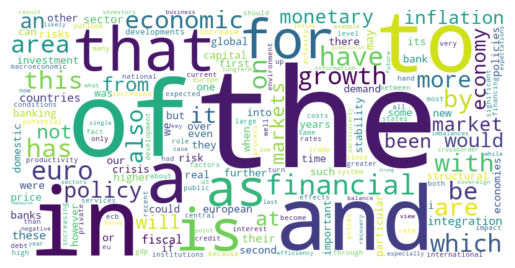

In [4]:
# Create a corpus
corpus = statements["text"].to_list()

# Collapse the corpus into a single list of words
words = [word for text in corpus for word in text.split()]

# Create value counts
word_freq = pd.Series(words).value_counts()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


🗣️ **CLASSROOM DISCUSSION:** What went wrong here? Edit the code to get more appropriate output.

*We used the unfiltered text column which contains stopwords - words that are both highly frequent in statements and yet entirely uninformative regarding the kinds of issues being discussed.*

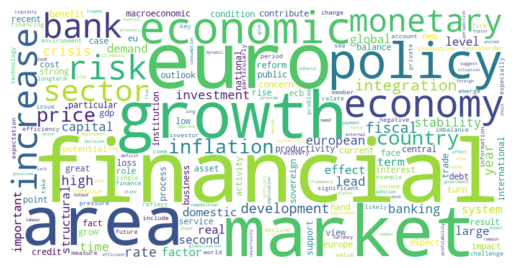

In [5]:
# Create a corpus
corpus = statements["text_cleaned"].to_list()

# Collapse the corpus into a single list of words
words = [word for text in corpus for word in text.split()]

# Create value counts
word_freq = pd.Series(words).value_counts()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


To understand which words are most indicative of positive and negative sentiment, we can use `dfm` to predict our sentiment column using logistic regression.  We can then plot the top 10 largest absolute coefficients for the data.

In [6]:
# Create our target using the sentiment column
y = statements["sentiment"]

# Train a logistic regression model
logit_model = LogisticRegression()
logit_model.fit(dfm, y)

# Get word importance (coefficients)
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = logit_model.coef_.flatten()

# Create a data frame for plotting purposes
coef_df = (pd.DataFrame(
        {
            "feature": feature_names,
            "coefficient": coefficients,
            "abs_coefficient": np.abs(coefficients),
            "sign": np.where(coefficients > 0, "positive", "negative")
        }
    )
    .groupby("sign")
    [["feature","coefficient","sign","abs_coefficient"]]
    .apply(lambda x: x.nlargest(10, "abs_coefficient"))
    .sort_values("coefficient", ascending=True)
    )

# Plot results
(
    ggplot(coef_df, aes("coefficient","feature",fill="sign")) +
    geom_bar(stat="identity") +
    theme(legend_position="none",
          panel_grid_major_y = element_blank()) +
    labs(x = "Logit coefficient", y = "")
)

🗣️ **CLASSROOM DISCUSSION:** Which words are most indicative of positive / negative sentiment?

*Words such as growth and integration are indicative of positive sentiment, whereas crisis and risk are indicative of negative sentiment.*

:::callout-note

Note that, instead of building a logistic regression model based on all the DFM features, you could consider applying dimensionality reduction to cut down the number of features and keep the most relevant ones.

However, the DFM matrix is a highly sparse matrix (i.e most of the entries are 0). Both PCA and UMAP struggle with sparse matrices for varying reasons:

- PCA identifies principal components based on variance; however in sparse matrices, variance is artificially deflated by massive zero entries, leading to principal components that don't meaningfully represent data variance. Moreover, implicitly assumes data is normally distributed but however, the data in sparse matrices is anything but normally distributed.
- UMAP starts with constructing a nearest-neighbour graph in the high dimensional space: when the data is highly sparse, the distance calculations needed to construct the graph are distorted and it becomes difficult to identify meaningful neighbours. In short, to work correctly, UMAP assumes a more uniform data distribution than a sparse text DFM provides.

So, what can we use for dimensionality reduction instead?

We can use LSA (Latent Semantic Analysis) (see [here](https://zilliz.com/glossary/latent-semantic-analysis-(lsa)) for details on LSA) as it is a method that is designed specifically for sparse text matrices.

:::

# A supervised learning application of NLP - predicting ECB sentiment (30 minutes)

Let's print the first 5 rows of `dfm`.

In [7]:
print(dfm.head())

   ability  able  accelerate  access  accompany  account  accumulation  \
0        0     0           0       0          0        0             0   
1        0     0           0       0          0        0             0   
2        0     0           0       0          0        0             0   
3        0     0           0       0          0        0             0   
4        0     0           0       0          0        0             0   

   achieve  act  action  ...  weaken  weakness  weigh  welfare  well  wide  \
0        0    0       0  ...       0         0      0        0     0     0   
1        0    0       0  ...       0         0      0        0     0     0   
2        0    0       0  ...       0         0      0        0     0     0   
3        0    0       0  ...       0         0      0        0     0     0   
4        0    0       0  ...       0         0      0        0     0     0   

   work  world  worsen  year  
0     0      0       0     0  
1     0      0       0  

We have 712 features that can be used for building a classification model. 

👉 **NOTE:** In doing this, we are using a Bag of Words (BoW) model - whereby a text (such as a sentence or document) is treated as an unordered collection (or "bag") of individual words, ignoring grammar and word order.  Each word in the text is represented by its frequency (or presence/absence) in the document. This means that the text is converted into a vector where each dimension corresponds to a unique word in the vocabulary (a list of all words across the dataset). The value in each dimension represents how often a word appears in the document.  The BoW model assumes that the context or syntax (word order, grammatical structure) does not matter. It only focuses on which words appear and how often.

Next, let's create a train / test split, making sure to set a random seed and stratify the split by the outcome.  We will use `dfm` as comprising the totality of the features.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dfm, y, stratify=y, random_state=123)

We can now specify a classification algorithm. We will opt for a Lasso model here, using an instantiation of `LogisticRegression`.

In [9]:
# Instantiate a lasso classification model
lasso_classifier = LogisticRegression(penalty="l1",solver="liblinear",C=0.1,max_iter=1000,random_state=123)

# Fit the model to the training data
_ = lasso_classifier.fit(X_train, y_train)

Next, we can build a data frame of the top 20 absolute lasso coefficients and plot the results.

In [10]:
# Create a data frame of the top 20 features
top_20_feats = (
    pd.DataFrame({"features": lasso_classifier.feature_names_in_, 
                  "coefs": lasso_classifier.coef_.reshape(-1)})
    .assign(abs_coefs = lambda x: np.abs(x["coefs"]),
            sign = lambda x: np.where(x["coefs"] > 0, "Positive", "Negative"))
    .sort_values("abs_coefs")
    .tail(20)
)

# Plot the output
(
    ggplot(top_20_feats, aes("abs_coefs", "features", fill = "sign")) +
    geom_bar(stat = "identity", tooltips=layer_tooltips().line("Abs. coef. value: @abs_coefs").line("@sign")) +
    theme(panel_grid_major_y=element_blank()) +
    labs(x = "Absolute coefficient value", y = "Features", fill = "Influence")
)

🗣️ **CLASSROOM DISCUSSION:**

Which features are most important?

*Integration, growth and trade are the top 3 words that predict positive sentiment by the ECB.  Crisis, risk and inflation are the top 3 words that predict negative sentiment.*

We can also use Shapley values, both for each observation and in the aggregate.

ℹ️ **Information:**

Shapley values have a game theoretical underpinning. The basic idea is that we want to assign "credit" to a given feature for improving the performance of a model when compared to all possible sets (or "coalitions") of features. Instead of looking at the *global* contribution of each feature, as with variable importance, we compute the marginal contribution feature *j* makes to the prediction of an outcome for each observation, relative to the potential combination of features had the *j*th feature not been present. The Shapley value is then calculated as the average of all these marginal contributions across all observations. Shapley values can be calculated for all kinds of model, which makes them highly useful quantities of interest to calculate.

For a more in-depth look at Shapley values, check out "Interpretable Machine Learning" from Christoph Molnar (click [here](https://christophm.github.io/interpretable-ml-book/shapley.html) for the relevant section).

We can calculate Shapley values easily in Python.

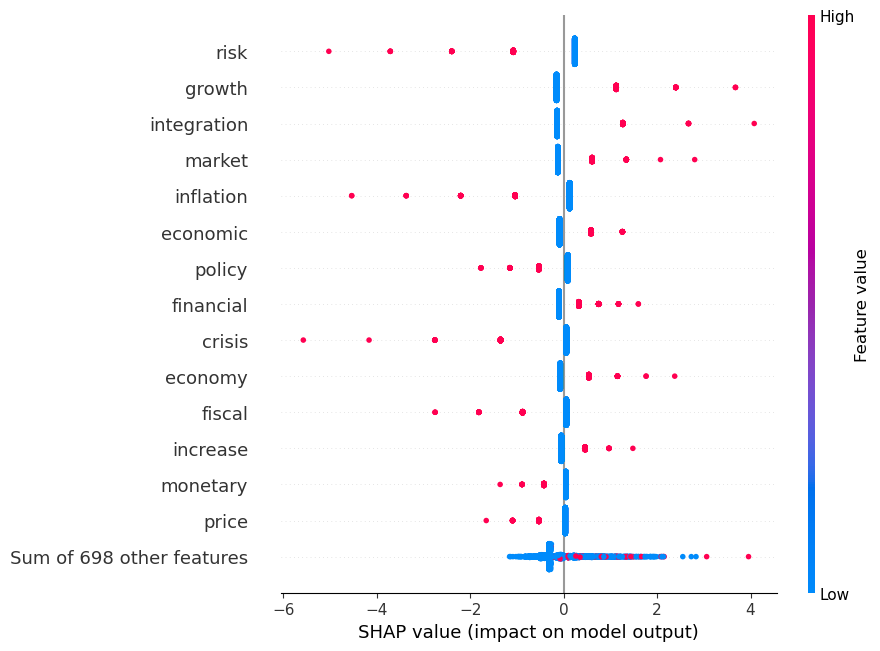

In [11]:
# Instantiate a Shapley values calculator, using the model and the training set features
explainer = shap.Explainer(lasso_classifier, X_train)

# Apply the calculator to the traing set features
shap_values = explainer(X_train)


# Create a "bee swarm" plot
shap.plots.beeswarm(shap_values, max_display=15)

👉 **NOTE:**

The "beeswarm" plot displays SHAP values per row of data.

🗣️ **CLASSROOM DISCUSSION:**

Which features are most important? Which make the most sense?

*"Risk", "growth", "integration", "market" and "inflation" are the 5 most important positive features according to the Shapley values importance plot.*

Let's apply this model to the test set. Present a confusion matrix and evaluation metric of your choice.

Our model predicting ECB sentiment has an f1-score of 0.83, not bad!


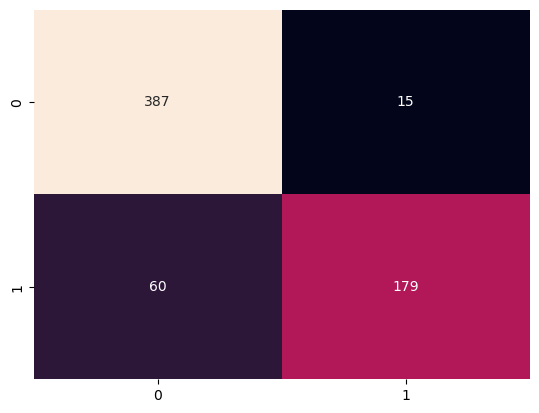

In [12]:
# Apply class predictions to the test set
predictions = lasso_classifier.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display confusion matrix
sns.heatmap(cm, annot=True, fmt="", cbar=False)

# f1-score
print(f"Our model predicting ECB sentiment has an f1-score of {np.round(f1_score(y_test, predictions), 2)}, not bad!")

# An unsupervised application of NLP - Finding ECB topics using Latent Dirichlet Allocation (30 minutes)

Topic models are often used in social sciences to understand text data. These algorithms cluster words that are frequently used together across different documents into distinct topics (the number of which is set by the user). Each word is then ranked by how indicative they are of a given topic using some kind of score, of which there are many.

We will pick 2 topics to begin with.  We will need to create 2 new data structures:

-   A corpus dictionary, which assigns a unique token ID to all tokens across the corpus.
-   A count of the number of times a token in the corpus dictionary appears in a given document.

Let's create a corpus, which consists of a collection of documents.

In [13]:
# Create a list of statements
corpus = statements["text"].to_list()

# Print the first 10 entries in the corpus
corpus[0:10]

['target2 is seen as a tool to promote the further integration of its users internal processes including the centralisation of euro payment business',
 'the slovak republic for example is now home to a number of sizeable car manufacturing plants and over time it may become the detroit of the european union',
 'the earlier this happens the earlier economic activity employment and innovation in the eu can be lifted to a higher level',
 'the bank has made essential contributions in koreas economic development the reform of the countrys financial system and its integration into the global financial system',
 'moreover the economic size and welldeveloped financial markets of the euro area inevitably mean that it will play a role in the internationalisation of chinas currency',
 'deeper financial integration can offer more possibilities for financial institutions to better manage and diversify their relevant risks and realise economies of scale',
 'the level of productivity in the financial 

We can then tokenise our corpus, meaning (in this case) that we can break our cleaned documents into distinct words that are not included in the stopwords list.

In [14]:
# Create a tokenised corpus using a nested list comprehension
corpus_tokenised = [
    [word for word in document.split() if word not in stopwords]
    for document in corpus
]

# Print the first tokenised corpus
corpus_tokenised[0]

['target2',
 'seen',
 'tool',
 'promote',
 'integration',
 'users',
 'internal',
 'processes',
 'including',
 'centralisation',
 'euro',
 'payment',
 'business']

We can now create the corpus dictionary.

In [15]:
# Create a corpus dictionary
corpus_dictionary = corpora.Dictionary(corpus_tokenised)

# Print the dictionary
print(corpus_dictionary)

Dictionary<5288 unique tokens: ['business', 'centralisation', 'euro', 'including', 'integration']...>


And the corpus count, which returns a list of tuples for each document, where the first element consists of the token ID and the second reports the count of that token in each document.

In [16]:
# Create a statement bag of words (bow)
corpus_count = [corpus_dictionary.doc2bow(text) for text in corpus_tokenised]

# Print the count for the first two documents
corpus_count[0:2]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1)],
 [(13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1)]]

We can now compile our LDA model.

In [17]:
# Train an LDA model
lda_model = LdaModel(corpus=corpus_count,
                     id2word=corpus_dictionary,
                     num_topics=2, 
                     random_state=123,
                     passes=10,     
                     iterations=50)

After having compiled our 2-topic model, we can now try to understand what each topic signifies "under the hood".  To do this, we can use a nested list comprehension where we employ the `get_topic_terms` method of `lda_model` to create a list of top 7 words for each topic.

In [18]:
# List comprehension to isolate topics
top_words = [
    [corpus_dictionary[word_id] for word_id, _ in lda_model.get_topic_terms(topic_id, topn=7)]
    for topic_id in range(lda_model.num_topics)
]

# Print results
for i, words in enumerate(top_words):
    print(f"Topic {i+1}: {', '.join(words)}")

Topic 1: euro, policy, area, financial, monetary, fiscal, economic
Topic 2: growth, inflation, financial, market, banks, integration, economic


🗣️ **CLASSROOM DISCUSSION:**

Can we intuitively intepret the topics?

*Yes, topic 1 looks at policy related issues in the Euro area such as inflation.  Topic 2 discusses issues relating to finance and markets.*

👉 **NOTE:**

-   The top 7 words are decided upon as the LDA model assigns a probability of each word appearing in a given topic.  The words that have the highest probabilities are therefore the most important.
-   We use a trusty throwaway variable (`_`) in this context as `get_topic_terms` creates a tuple, with the word ID and word probability.  Since we do not want the word probability, we tell Python to ignore this.

## How many topics?

How did we arrive at only 2 topics?  Why not, say, 10? We can calculate performance metrics such as semantic coherence and perplexity:

-   **Semantic coherence:** a measure of how commonly the most probable words in a topic co-occur. Note that one limitation of semantic coherence is that it is highest when the number of topics is low
-   **Perplexity:** a measure of how well a model predicts a set of documents.

We can set up a `for` loop over a range of topic numbers like so.

In [19]:
# Instantiate empty lists for perplexity and coherence scores
perplexities = []
coherences = []

# Create a range of topic numbers from 1 to 10
topic_numbers = range(1,11)

for topic in topic_numbers:
    
    # Train LDA model
    lda_model = LdaModel(corpus=corpus_count,
                         id2word=corpus_dictionary,
                         num_topics=topic,  
                         random_state=123,
                         passes=10,     
                         iterations=50)
    
    # Calculate perplexity
    perplexity = lda_model.log_perplexity(corpus_count)
    
    # Calculate coherence
    coherence = CoherenceModel(model=lda_model, corpus=corpus_count, coherence='u_mass').get_coherence()
    
    # Append values to list
    perplexities.append(perplexity)
    coherences.append(coherence)   

After this, we can create a data frame of the results by passing a dictionary to `pd.DataFrame`.  All we then need to do is stack our scores on top of one another, for plotting purposes.

In [20]:
# Create a data frame of results
tm_df = pd.DataFrame(
        {
            "topics": topic_numbers,
            "Coherence": coherences,
            "Perplexity": perplexities
        }
    )

# Pivot the data to a long data frame
tm_melted_df = pd.melt(tm_df, id_vars="topics", var_name = "metric", value_name= "score")

# Plot the results
(
    ggplot(tm_melted_df, aes("topics", "score")) +
    geom_point() +
    geom_line(linetype="dashed") +
    facet_wrap(facets="metric", scales="free_y") +
    labs(x = "Number of topics", y = "Score",
         title = "Two topics is the most coherent and one of the least perplexing numbers!",
         subtitle = "Experimenting with different topic numbers for LDA\n")
)